<a href="https://colab.research.google.com/github/iliaxant/DIP_HW_2_DCT_compression/blob/main/DIP_HW_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ψηφιακή Επεξεργασία Εικόνας**

## 2η Εργαστηριακή Εργασία - Ακαδημαικό έτος 2025-2026

## Ηλίας Ξανθόπουλος 58545

## GitHub Repo: https://github.com/iliaxant/DIP_HW_2_DCT_compression

## **Μέρος 0**: Προετοιμασία (Skip)

Mounting Google Drive και φόρτωση εικόνων.

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import shutil
import os

data_dir = '/content/drive/MyDrive/DIP/2nd_Ex/'
source_files = os.listdir(data_dir)
for source_file in source_files:
  source_dir = os.path.join(data_dir, source_file)
  shutil.copy(source_dir,'/content/')

print("Images copied successfully to /content directory.")

Images copied successfully to /content directory.


## **Μέρος 1**

1) Επιλογή εικόνας και εφαρμογή των εκτιμητών:

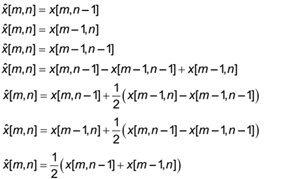


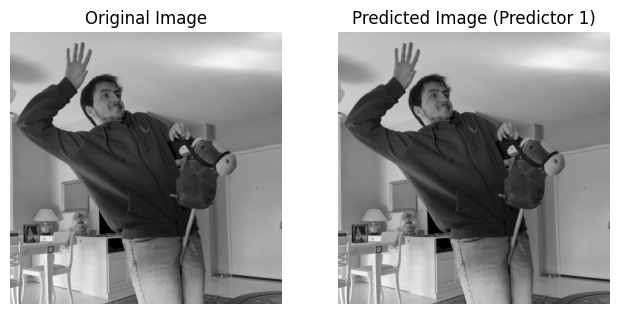

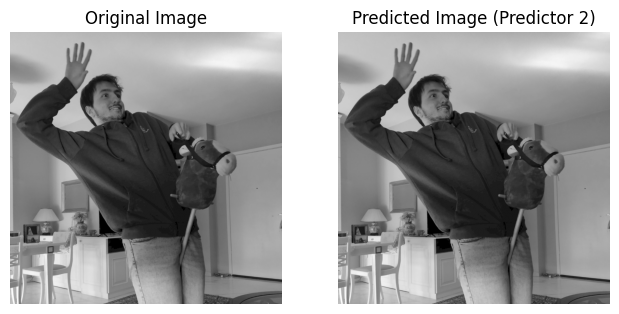

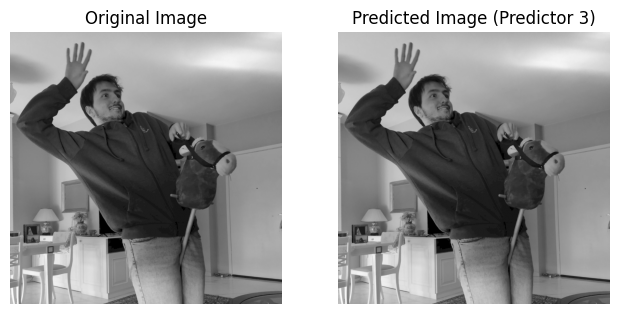

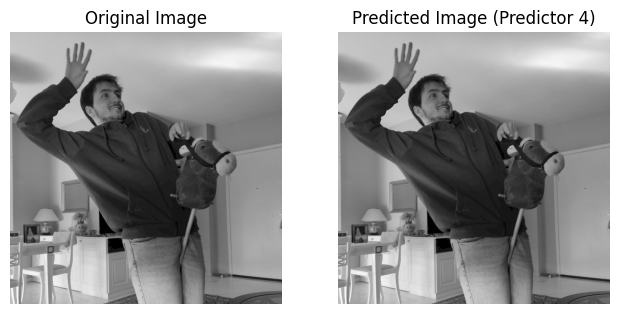

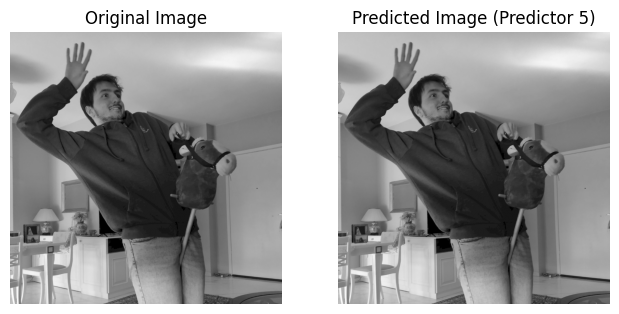

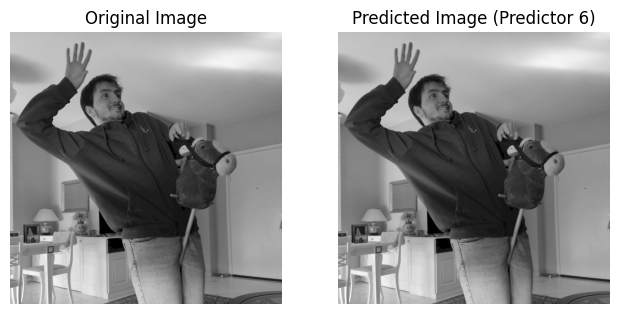

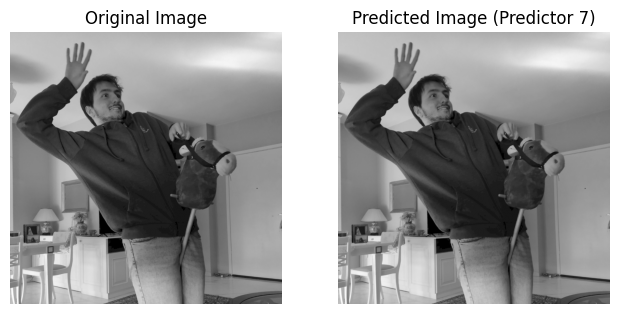

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('rider_square.png', cv2.IMREAD_GRAYSCALE)

# Ορισμός των εκτιμητών της εικόνας του παραπάνω block κειμένου (ορισμός με την
# ίδια σειρά που απεικονίζονται)
predictor1_mask=np.array([[0, 0 ,0],
                          [1, 0, 0],
                          [0, 0, 0]])

predictor2_mask=np.array([[0, 1, 0],
                          [0, 0, 0],
                          [0, 0, 0]])

predictor3_mask=np.array([[1, 0, 0],
                          [0, 0, 0],
                          [0, 0, 0]])

predictor4_mask=np.array([[-1, 1, 0],
                          [1, 0, 0],
                          [0, 0, 0]])

predictor5_mask=np.array([[-0.5, 0.5, 0],
                          [1, 0, 0],
                          [0, 0, 0]])

predictor6_mask=np.array([[-0.5, 1, 0],
                          [0.5, 0, 0],
                          [0, 0, 0]])

predictor7_mask=np.array([[0, 0.5, 0],
                          [0.5, 0, 0],
                          [0, 0, 0]])

predictor_masks = [predictor1_mask, predictor2_mask, predictor3_mask,
                   predictor4_mask, predictor5_mask, predictor6_mask,
                   predictor7_mask]


predicted_images = []

for i, predictor_mask in enumerate(predictor_masks):

  predicted_image = cv2.filter2D(image, -1, predictor_mask)
  predicted_images.append(predicted_image)

  plt.figure(figsize=(12, 12))

  plt.subplot(3, 3, 1)
  plt.imshow(image, cmap='gray')
  plt.title('Original Image')
  plt.axis('off')

  plt.subplot(3, 3, 2)
  plt.imshow(predicted_image, cmap='gray')
  plt.title(f'Predicted Image (Predictor {i+1})')
  plt.axis('off')

  plt.show()

2) Υπολογισμός για κάθε predictor του σφάλματος, του ιστογράμματος και της εντροπίας του σφάλματος. Επιλογή του εκτιμητή με την χαμηλότερη εντροπία σφάλματος.

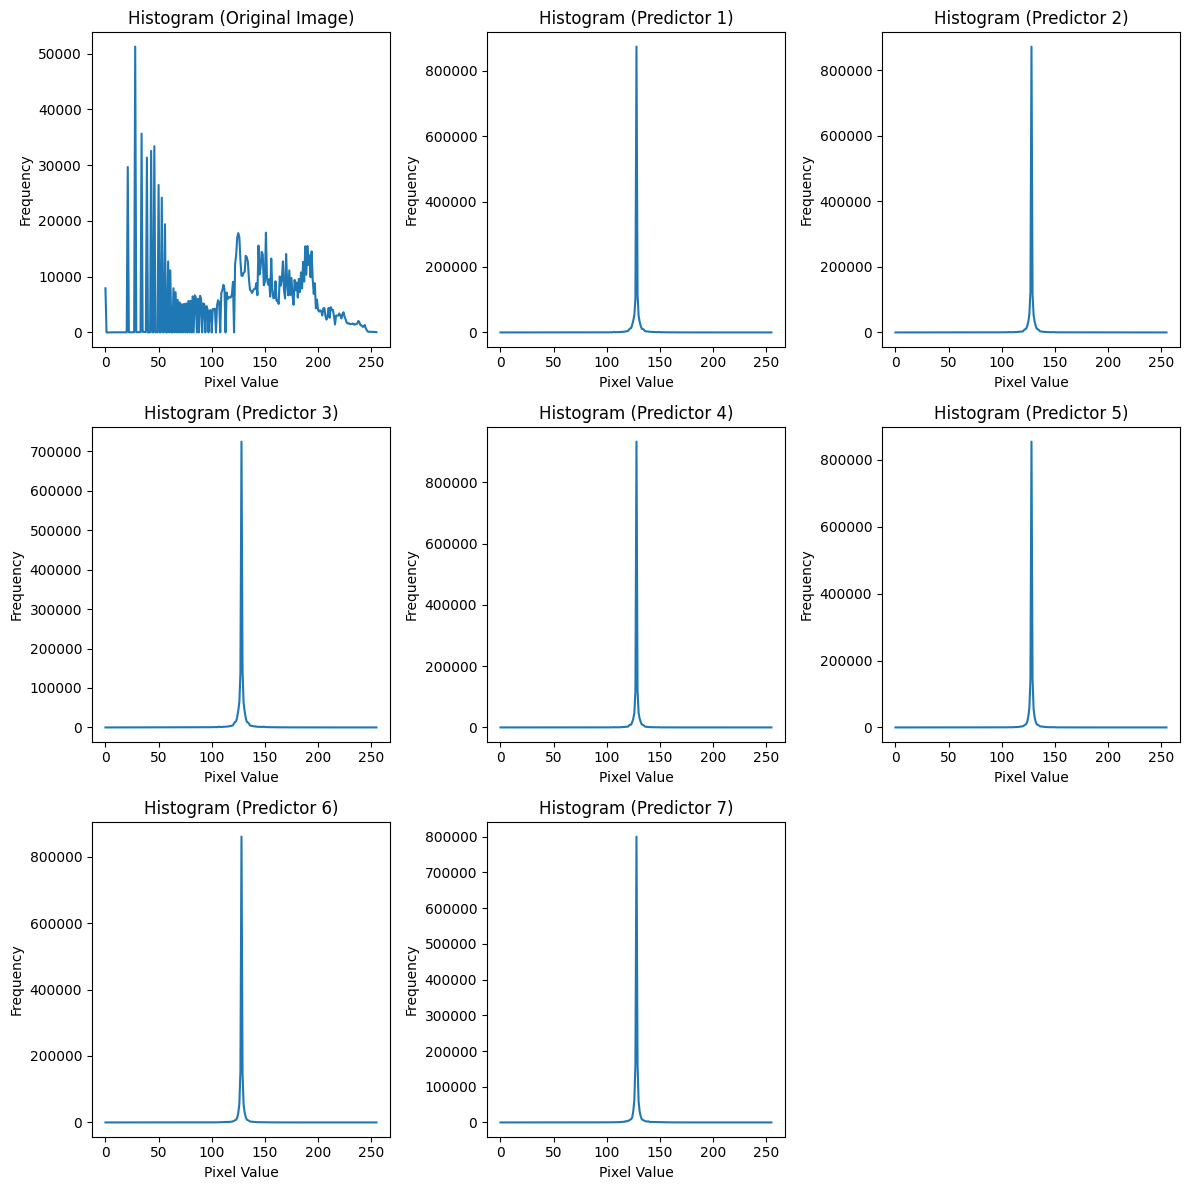


Entropy for Original image: 7.0676
Entropy for Predictor 1: 2.5861
Entropy for Predictor 2: 2.5243
Entropy for Predictor 3: 3.0894
Entropy for Predictor 4: 2.2080
Entropy for Predictor 5: 2.4254
Entropy for Predictor 6: 2.3670
Entropy for Predictor 7: 2.5627

Best Predictor (lowest entropy): Predictor 4 (Entropy = 2.2080)


In [6]:
def compute_entropy(histogram):

    histogram_norm = histogram / np.sum(histogram)
    entropy_value = -np.sum(histogram_norm * np.log2(histogram_norm + 1e-10))  # Η μικρή ποσότητα για αποφυγή Not a number

    return entropy_value


histogram_original,_ = np.histogram(image, bins= 256,range = (0,255))
entropy_original = compute_entropy(histogram_original)

plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1)
plt.plot(histogram_original)
plt.title(f'Histogram (Original Image)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

prediction_errors = []
entropies = []

for i, predicted_image in enumerate(predicted_images):

  prediction_error = image.astype(int) - predicted_image.astype(int)
  prediction_errors.append(prediction_error)

  histogram_pred, _ = np.histogram(prediction_error.flatten(), bins= 256,range = (-128,128))

  entropy = compute_entropy(histogram_pred)
  entropies.append(entropy)

  plt.subplot(3, 3, i+2)
  plt.plot(histogram_pred)
  plt.title(f'Histogram (Predictor {i+1})')
  plt.xlabel('Pixel Value')
  plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


print()
print(f'Entropy for Original image: {entropy_original:.4f}')

for i, entropy in enumerate(entropies):
    print(f'Entropy for Predictor {i+1}: {entropy:.4f}')

min_entropy = min(entropies)
min_ind = entropies.index(min_entropy)

print()
print(f'Best Predictor (lowest entropy): Predictor {min_ind + 1} (Entropy = {min_entropy:.4f})')


**Συμπίεση JPEG με απώλειες**

1. Φορτώστε την εικόνα dog_square.png και χρησιμοποιώντας cv2.resize εκτελέστε κλιμάκωση της εικόνωας ώστε να έχει διαστάσεις 256x256.
2. Μετασχηματίστε την εικόνα σε χρωματικό χώρο YCbCr
3. Εκτελέστε υποδειγματοληψία στις χρωματικές συνιστώσες


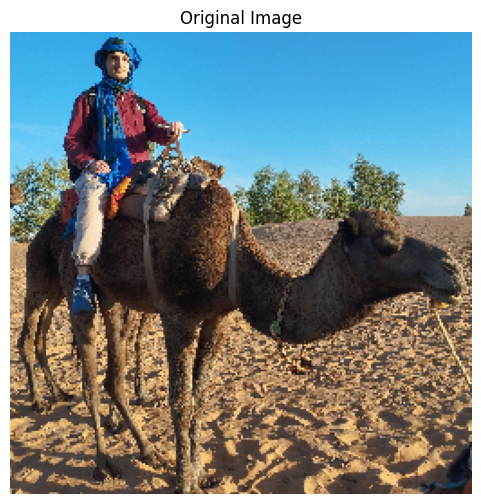

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from skimage.util import view_as_blocks
import heapq
from collections import defaultdict
import urllib.request



image= cv2.imread('rider_square.png')
image = cv2.resize(image, (256,256))
ycbcr_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

y, cr, cb = cv2.split(ycbcr_image)

Cb_downsampled= cb[::2,::2]
Cr_downsampled= cr[::2,::2]



# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()


**2D-DCT Μετασχηματισμός και κβάντιση συντελεστών**

Εκτελέστε τον ακόλουθο κώδικα που πραγματοποιεί DCT μετασχηματισμό σε 8x8 blocks των καναλιών. Προβάλετε το σχήμα των εμεξεργασμένων καταλιών (Y_processed,...) . Επιλέξτε ένα DCT και προβάλετε το πριν και μετά την κβάντιση.



(np.float64(-0.5), np.float64(7.5), np.float64(7.5), np.float64(-0.5))

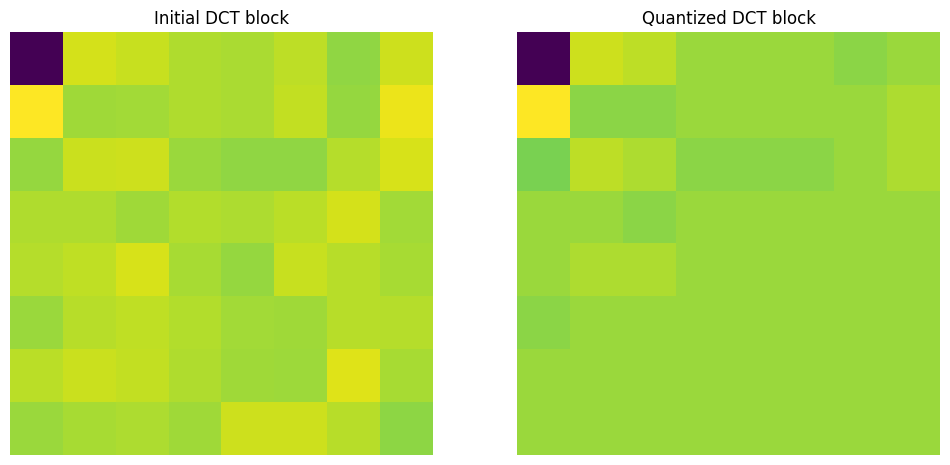

In [ ]:
# Function to compute the 2D DCT of an 8x8 block
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

# Quantization matrices for Y and CbCr channels
QY = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

QY_high = np.array([
    [8, 6, 5, 8, 12, 20, 26, 31],
    [6, 6, 7, 10, 13, 29, 30, 28],
    [7, 7, 8, 12, 20, 29, 35, 28],
    [7, 9, 12, 15, 26, 44, 40, 31],
    [9, 12, 19, 28, 34, 55, 52, 39],
    [12, 18, 28, 32, 40, 52, 56, 46],
    [25, 32, 39, 44, 52, 61, 60, 51],
    [36, 46, 48, 49, 56, 50, 52, 50]
])

QY_low = np.array([
    [32, 22, 20, 32, 48, 80, 102, 122],
    [24, 24, 28, 38, 52, 116, 120, 110],
    [28, 26, 32, 48, 80, 114, 138, 112],
    [28, 34, 44, 58, 102, 174, 160, 124],
    [36, 44, 74, 112, 136, 218, 206, 154],
    [48, 70, 110, 128, 162, 208, 226, 184],
    [98, 128, 156, 174, 206, 242, 240, 202],
    [144, 184, 190, 196, 224, 200, 206, 198]
])

QC = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

# Quantize DCT coefficients
def quantize(block, q_matrix):
    return np.round(block / q_matrix)


# Process each channel with block-wise DCT and quantization
def process_channel(channel, q_matrix):
    blocks = view_as_blocks(channel, block_shape=(8, 8))
    processed_blocks = np.zeros_like(blocks)
    for i in range(blocks.shape[0]):
        for j in range(blocks.shape[1]):
            block = blocks[i, j]
            dct_block = dct2(block - 128)
            quant_block = quantize(dct_block, q_matrix)
            processed_blocks[i, j] = quant_block
    return processed_blocks

Y_processed = process_channel(y.astype('int'), QY)
Cb_processed = process_channel(Cb_downsampled.astype('int'), QC)
Cr_processed = process_channel(Cr_downsampled.astype('int'), QC)

Yblocks = view_as_blocks(y.astype(int), block_shape=(8, 8))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(dct2(Yblocks[10,10] - 128))
plt.title('Initial DCT block')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Y_processed[10,10])
plt.title('Quantized DCT block')
plt.axis('off')



**Κωδικοποίηση Εντροπίας των κβαντισμένων συντελεστών**

Εκτελέστε τον ακόλουθο κώδικα που υλοποιήσει συμπίεση Huffman στα κβαντισμένα DCT blocks.
1. Συμπληρώστε τον κώδικα ώστε να υπολογίσετε τον λόγο συμπίεσης που επιτυγχάνεται.
2. Προβάλετε και παρατηρείστε τους κώδικες Huffman που δημιουργούνται.

In [ ]:
# Huffman coding
class HuffmanNode:
    def __init__(self, value, frequency):
        self.value = value
        self.frequency = frequency
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.frequency < other.frequency

def build_huffman_tree(frequencies):
    heap = [HuffmanNode(value, freq) for value, freq in frequencies.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(None, node1.frequency + node2.frequency)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)
    return heap[0]

def build_huffman_codes(tree, prefix="", codebook={}):
    if tree.value is not None:
        codebook[tree.value] = prefix
    else:
        if tree.left:
            build_huffman_codes(tree.left, prefix + "0", codebook)
        if tree.right:
            build_huffman_codes(tree.right, prefix + "1", codebook)
    return codebook

def huffman_encode(data):
    frequencies = defaultdict(int)
    for item in data:
        frequencies[item] += 1
    huffman_tree = build_huffman_tree(frequencies)
    huffman_codes = build_huffman_codes(huffman_tree)
    encoded_data = ''.join([huffman_codes[item] for item in data])
    return encoded_data, huffman_codes

# Zigzag order
zigzag_index = np.array([
    [0, 1, 5, 6, 14, 15, 27, 28],
    [2, 4, 7, 13, 16, 26, 29, 42],
    [3, 8, 12, 17, 25, 30, 41, 43],
    [9, 11, 18, 24, 31, 40, 44, 53],
    [10, 19, 23, 32, 39, 45, 52, 54],
    [20, 22, 33, 38, 46, 51, 55, 60],
    [21, 34, 37, 47, 50, 56, 59, 61],
    [35, 36, 48, 49, 57, 58, 62, 63]
])

# Function to apply zigzag scan
def zigzag_scan(block):
    return block.flatten()[zigzag_index.flatten()]

# Encode processed Y channel using Huffman coding
#Y_flattened = Y_processed.flatten()
Y_zigzag = [zigzag_scan(block) for block in Y_processed.reshape(-1, 8, 8)]
Cb_zigzag = [zigzag_scan(block) for block in Cb_processed.reshape(-1, 8, 8)]
Cr_zigzag = [zigzag_scan(block) for block in Cr_processed.reshape(-1, 8, 8)]

Y_flattened = np.concatenate(Y_zigzag).astype(int)
Cb_flattened = np.concatenate(Cb_zigzag).astype(int)
Cr_flattened = np.concatenate(Cr_zigzag).astype(int)

encoded_Y, huffman_codes_Y = huffman_encode(Y_flattened)
encoded_Cb, huffman_codes_Cb = huffman_encode(Cb_flattened)
encoded_Cr, huffman_codes_Cr = huffman_encode(Cr_flattened)

encoded_bit_stream = encoded_Y + encoded_Cb + encoded_Cr

# Display the first 100 bits of the final bit stream for brevity
print(f"Encoded Bit Stream (first 100 bits): {encoded_bit_stream[:100]}")

# Calculate compression ratio

original_size = 256*256*3

compressed_size = len(encoded_bit_stream) //8

compression_ratio = compressed_size / original_size

print(f"Compression Ratio: {compression_ratio:.4f}")

print(huffman_codes_Y)

Encoded Bit Stream (first 100 bits): 0110010111111111111111111111111111111111111111111111111111111111111111101100101111111111111111100111
Compression Ratio: 0.1110
{np.int64(-11): '01100001001', np.int64(11): '000101110', np.int64(-10): '01100001010', np.int64(-13): '01100000110', np.int64(-18): '01100000111', np.int64(26): '00000011110', np.int64(-42): '00000011111', np.int64(-56): '0000010000000', np.int64(-35): '0000010000001', np.int64(38): '0000010000010', np.int64(33): '0000010000011', np.int64(24): '000000011', np.int64(-23): '00000100010', np.int64(-28): '0110001', np.int64(13): '01100001000', np.int64(14): '00000000', np.int64(-14): '0110011010', np.int64(7): '000001', np.int64(3): '00001', np.int64(-4): '0001010', np.int64(4): '0111100', np.int64(-12): '011001100', np.int64(-50): '00011000100', np.int64(-21): '011001110', np.int64(-16): '01100000100', np.int64(-34): '000110010000', np.int64(29): '000110010001', np.int64(-49): '00011001001', np.int64(16): '0001100101', np.int6

Εκτελέστε τον ακόλουθο κώδικα ώστε να οπτικοποιήσετε χωρικά τους συντελεστές DCT

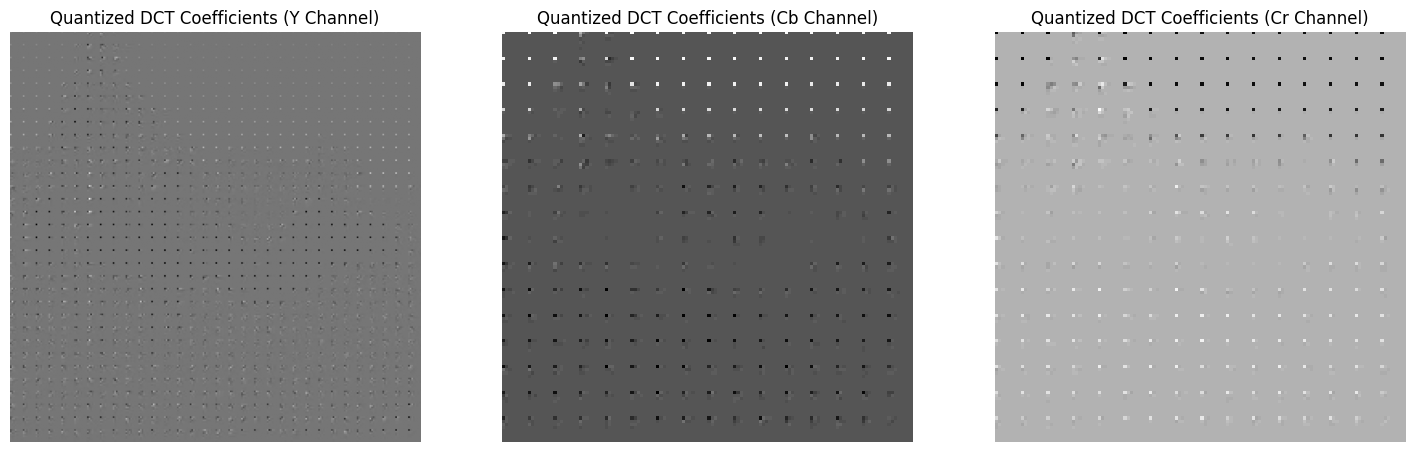

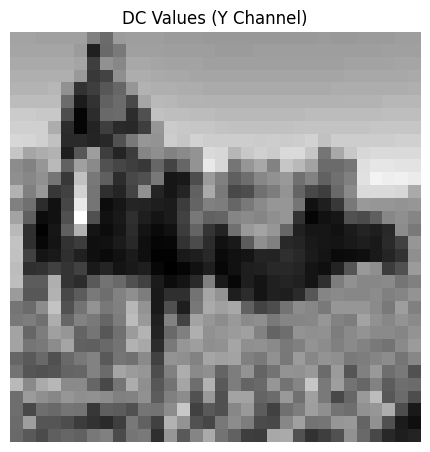

In [ ]:

# Visualize the quantized DCT coefficients of Y channel
def visualize_quantized_dct(processed_blocks):
    reconstructed_image = np.zeros((processed_blocks.shape[0] * 8, processed_blocks.shape[1] * 8))
    for i in range(processed_blocks.shape[0]):
        for j in range(processed_blocks.shape[1]):
            block = processed_blocks[i, j]
            for m in range(8):
                for n in range(8):
                    reconstructed_image[i * 8 + m, j * 8 + n] = block[m, n]
    return reconstructed_image

visualized_dct_Y = visualize_quantized_dct(Y_processed)
visualized_dct_Cb= visualize_quantized_dct(Cb_processed)
visualized_dct_Cr = visualize_quantized_dct(Cr_processed)



plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(visualized_dct_Y, cmap='gray')
plt.title('Quantized DCT Coefficients (Y Channel)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(visualized_dct_Cb, cmap='gray')
plt.title('Quantized DCT Coefficients (Cb Channel)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(visualized_dct_Cr, cmap='gray')
plt.title('Quantized DCT Coefficients (Cr Channel)')
plt.axis('off')
plt.show()

flatten_blocks = Y_processed.reshape(Y_processed.shape[0], Y_processed.shape[1], -1)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(flatten_blocks[:,:,0], cmap='gray')
plt.title('DC Values (Y Channel)')
plt.axis('off')
plt.show()

